# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name='Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=False)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [5]:
env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.0


When finished, you can close the environment.

In [6]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [7]:
from collections import deque
import random
import torch
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

from ddpg_agent import Agent # Agent taken from https://github.com/udacity/deep-reinforcement-learning/blob/master/ddpg-pendulum/ddpg_agent.py


In [8]:
agent = Agent(state_size=state_size, action_size=action_size, random_seed=2)

# 5. Training!

Total score (averaged over agents) this episode: 1.1099999751895666
Episode 1	Average Score: 1.11
--- 14.468080282211304 seconds ---
Total score (averaged over agents) this episode: 0.30999999307096004
Episode 2	Average Score: 0.71
--- 18.227809190750122 seconds ---
Total score (averaged over agents) this episode: 0.8499999810010195
Episode 3	Average Score: 0.76
--- 18.22128129005432 seconds ---
Total score (averaged over agents) this episode: 1.1099999751895666
Episode 4	Average Score: 0.84
--- 18.343459844589233 seconds ---
Total score (averaged over agents) this episode: 0.5099999886006117
Episode 5	Average Score: 0.78
--- 18.394530534744263 seconds ---
Total score (averaged over agents) this episode: 1.7499999608844519
Episode 6	Average Score: 0.94
--- 18.441455841064453 seconds ---
Total score (averaged over agents) this episode: 0.35999999195337296
Episode 7	Average Score: 0.86
--- 18.310797691345215 seconds ---
Total score (averaged over agents) this episode: 0.4999999888241291


Total score (averaged over agents) this episode: 3.659999918192625
Episode 63	Average Score: 2.26
--- 17.81393551826477 seconds ---
Total score (averaged over agents) this episode: 2.8599999360740185
Episode 64	Average Score: 2.27
--- 19.188938856124878 seconds ---
Total score (averaged over agents) this episode: 3.7399999164044857
Episode 65	Average Score: 2.29
--- 17.98105549812317 seconds ---
Total score (averaged over agents) this episode: 3.659999918192625
Episode 66	Average Score: 2.31
--- 17.007182598114014 seconds ---
Total score (averaged over agents) this episode: 4.829999892041087
Episode 67	Average Score: 2.35
--- 19.158616304397583 seconds ---
Total score (averaged over agents) this episode: 7.919999822974205
Episode 68	Average Score: 2.43
--- 19.11681318283081 seconds ---
Total score (averaged over agents) this episode: 6.749999849125743
Episode 69	Average Score: 2.49
--- 19.143723011016846 seconds ---
Total score (averaged over agents) this episode: 4.169999906793237
Epi

Total score (averaged over agents) this episode: 7.039999842643738
Episode 125	Average Score: 4.07
--- 19.733855962753296 seconds ---
Total score (averaged over agents) this episode: 5.14999988488853
Episode 126	Average Score: 4.11
--- 19.851556062698364 seconds ---
Total score (averaged over agents) this episode: 4.679999895393848
Episode 127	Average Score: 4.14
--- 19.749101161956787 seconds ---
Total score (averaged over agents) this episode: 8.199999816715717
Episode 128	Average Score: 4.21
--- 19.810270309448242 seconds ---
Total score (averaged over agents) this episode: 6.96999984420836
Episode 129	Average Score: 4.25
--- 19.714149951934814 seconds ---
Total score (averaged over agents) this episode: 6.319999858736992
Episode 130	Average Score: 4.30
--- 19.67421007156372 seconds ---
Total score (averaged over agents) this episode: 8.189999816939235
Episode 131	Average Score: 4.37
--- 19.320748567581177 seconds ---
Total score (averaged over agents) this episode: 9.5299997869879


Total score (averaged over agents) this episode: 10.209999771788716
Episode 187	Average Score: 6.96
--- 20.291811227798462 seconds ---
Total score (averaged over agents) this episode: 9.44999978877604
Episode 188	Average Score: 7.03
--- 20.263349056243896 seconds ---
Total score (averaged over agents) this episode: 10.739999759942293
Episode 189	Average Score: 7.07
--- 20.408308029174805 seconds ---
Total score (averaged over agents) this episode: 9.129999795928597
Episode 190	Average Score: 7.11
--- 20.430460214614868 seconds ---
Total score (averaged over agents) this episode: 7.609999829903245
Episode 191	Average Score: 7.14
--- 20.345086812973022 seconds ---
Total score (averaged over agents) this episode: 7.989999821409583
Episode 192	Average Score: 7.15
--- 20.331172943115234 seconds ---
Total score (averaged over agents) this episode: 11.369999745860696
Episode 193	Average Score: 7.22
--- 20.354143619537354 seconds ---
Total score (averaged over agents) this episode: 9.159999795

Total score (averaged over agents) this episode: 8.569999808445573
Episode 248	Average Score: 9.78
--- 21.13817286491394 seconds ---
Total score (averaged over agents) this episode: 37.57999916002154
Episode 249	Average Score: 10.07
--- 20.439104318618774 seconds ---
Total score (averaged over agents) this episode: 12.539999719709158
Episode 250	Average Score: 10.13
--- 21.109346389770508 seconds ---
Total score (averaged over agents) this episode: 18.74999958090484
Episode 251	Average Score: 10.26
--- 21.06857919692993 seconds ---
Total score (averaged over agents) this episode: 12.349999723955989
Episode 252	Average Score: 10.29
--- 20.00658917427063 seconds ---
Total score (averaged over agents) this episode: 15.939999643713236
Episode 253	Average Score: 10.36
--- 21.102973461151123 seconds ---
Total score (averaged over agents) this episode: 16.179999638348818
Episode 254	Average Score: 10.46
--- 21.069141387939453 seconds ---
Total score (averaged over agents) this episode: 25.789

Total score (averaged over agents) this episode: 26.67999940365553
Episode 309	Average Score: 15.90
--- 21.99590516090393 seconds ---
Total score (averaged over agents) this episode: 19.98999955318868
Episode 310	Average Score: 16.00
--- 22.160805702209473 seconds ---
Total score (averaged over agents) this episode: 28.209999369457364
Episode 311	Average Score: 16.17
--- 22.178287744522095 seconds ---
Total score (averaged over agents) this episode: 24.529999451711774
Episode 312	Average Score: 16.35
--- 18.858344316482544 seconds ---
Total score (averaged over agents) this episode: 19.01999957486987
Episode 313	Average Score: 16.39
--- 20.88957667350769 seconds ---
Total score (averaged over agents) this episode: 18.729999581351876
Episode 314	Average Score: 16.47
--- 22.162920713424683 seconds ---
Total score (averaged over agents) this episode: 22.139999505132437
Episode 315	Average Score: 16.54
--- 21.295772552490234 seconds ---
Total score (averaged over agents) this episode: 21.1

Total score (averaged over agents) this episode: 27.279999390244484
Episode 370	Average Score: 22.87
--- 19.31864881515503 seconds ---
Total score (averaged over agents) this episode: 34.11999923735857
Episode 371	Average Score: 23.03
--- 23.26488423347473 seconds ---
Total score (averaged over agents) this episode: 30.069999327883124
Episode 372	Average Score: 23.09
--- 23.342623472213745 seconds ---
Total score (averaged over agents) this episode: 23.81999946758151
Episode 373	Average Score: 23.07
--- 23.354874849319458 seconds ---
Total score (averaged over agents) this episode: 39.25999912247062
Episode 374	Average Score: 23.36
--- 23.558867931365967 seconds ---
Total score (averaged over agents) this episode: 38.56999913789332
Episode 375	Average Score: 23.55
--- 23.400435209274292 seconds ---
Total score (averaged over agents) this episode: 30.719999313354492
Episode 376	Average Score: 23.61
--- 22.35279130935669 seconds ---
Total score (averaged over agents) this episode: 20.449

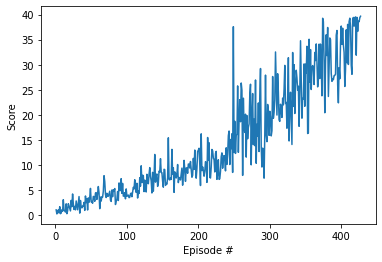

In [9]:
def ddpg(n_episodes=1000, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores_history = []
    for i_episode in range(1, n_episodes+1):
        start_time = time.time()
        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment  
        agent.reset()
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        while True:
            actions = agent.act(states, add_noise=False)
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            scores += env_info.rewards                         # update the score (for each agent)
            agent.step(states, actions, rewards, next_states, dones)
            states = next_states                               # roll over states to next time step
            if np.any(dones):                                  # exit loop if episode finished
                break
        scores_deque.append(scores)
        scores_history.append(scores)
        print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        print("--- %s seconds ---" % (time.time() - start_time))
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque) > 30.0:
            print('\rSOLVED!!  Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            break
        
    return scores_history

scores = ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

# 6. Evaluate on trained network

In [12]:
agent = Agent(state_size=state_size, action_size=action_size, random_seed=2)
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))

<All keys matched successfully>

In [13]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = agent.act(states, add_noise=False)
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    agent.step(states, actions, rewards, next_states, dones)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 28.399999365210533


In [ ]:
env.close()